<a href="https://colab.research.google.com/github/eunhyechoe/psyc60/blob/main/1_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Data Visualization**
Plot time-series, response patterns, and functional connectivity profiles

*Lastly Updated: Sep 28, 2024 (8:58 PM)*


### 1. Setup environment for Colab

Colab's virtual environment is temporary, so you need to install any non-default packages each time you run the script. Run the following cell first to set up the environment.

In [1]:
# cell 1
# Install the neuroboros package
# The '%%capture' is used to suppress the output in this webpage
%%capture
%pip install -U neuroboros

UsageError: Line magic function `%%capture` not found.


### 2. Import Libraries
Colab comes with pre-installed packages like `numpy` and `matplotlib`, so you can import them without installation. We also import `neuroboros` under the simplified alias `nb` for convenience.

In [2]:
# cell 2
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import neuroboros as nb

### 3. Define dataset

We will load the [StudyForrest](https://www.studyforrest.org/) data in `numpy` format using the `neuroboros` package. For detailed explanations of the code, refer to the [Neuroboros](https://neuroboros.github.io/tutorials/neuroimaging_data_matrix.html) tutorial.

In [3]:
# cell 3
# define dataset
# 'sids' contains the subject IDs of participants in the dataset
dset = nb.Forrest() # Load the Forrest dataset
sids = dset.subjects # Get all subject IDs
type(sids), len(sids) # Check the type and number of subject IDs

(list, 15)

Python uses zero-based indexing, meaning it starts counting from 0, not 1.

To get the subject IDs of the first three participants, use `sids[0:3]`.

In [4]:
sids[0:3]

['01', '02', '03']

`sids[:3]` gives the same result by loading the first three subject IDs from the top of the list.

In [5]:
sids[:3]

['01', '02', '03']

### 4. Load the data
We will set the first subject ID of the list to `sid`, and get the data as `dm` for the following parameters.

In [6]:
# cell 4
# Upload right hemisphere data for one subject (subject ID is sid[0]) for a specific run
sid = sids[0] # choose the first subject data
dm = dset.get_data(sid, 'forrest', 1, 'r')
# command structure: get_data(subject id, 'dataset', run number, 'hemisphere')

In [7]:
print(type(dm), dm.dtype)

<class 'numpy.ndarray'> float64


In [8]:
dm.shape

(451, 9666)

### 5. Plot Time-series
Each row of the data represents time points (TR = 0 to 450), and the columns correspond to cortical vertices (9675 in total). You can plot a response time series (TR) for a cortical vertex (vertex #).

Here, we will plot one for the first vertex index (vertex [0]), from TR 100 to TR 200.

Text(0.5, 1.0, 'FFA center vertex')

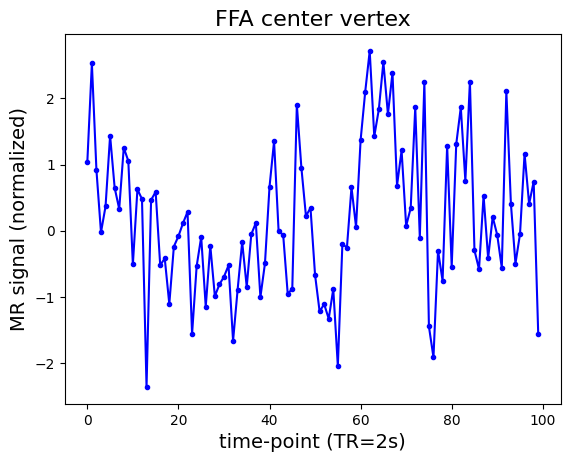

In [9]:
# cell 5
# Plot the time series data for a specific cortical vertex, for example, FFA
## FFA center vertex is identified as 6579 in ico32 resolution
time_series1 = dm[100:200,6579] # Extract data for time-points 100 to 200 for vertex 6579
plt.plot(time_series1, "b.-") # Plot the time series with blue dots and lines
plt.xlabel("time-point (TR=2s)", fontsize=14)
plt.ylabel("MR signal (normalized)", fontsize =14)
plt.title("FFA center vertex", fontsize=16)

### 6. Plot Response Pattern
You can also check the spatial response pattern for a specific time point, for example, TR = 47.

Let's start with the whole brain pattern.

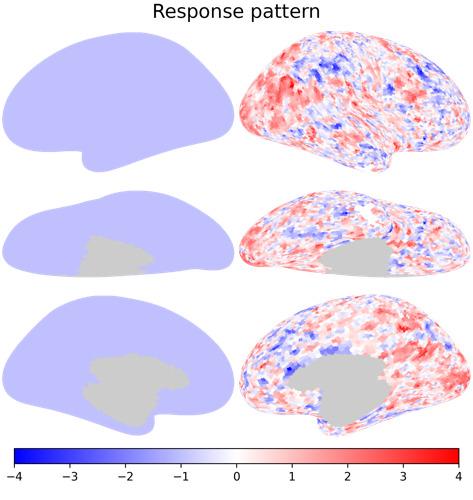

In [10]:
# cell 6
# Plot an image of the responses at a specific time point (TR = 47)

# Create blank arrays with the appropriate number of vertices for left and right hemispheres
lh_zero = np.zeros((9675))  # For left hemisphere vertices
rh_zero = np.zeros((9666))  # For right hemisphere vertices
lh_minus_one = np.zeros((9675))-1  # Initialize left hemisphere with -1 for a blue background
rh_minus_one = np.zeros((9666))-1  # Initialize right hemisphere with -1 for a blue background

# Plot an image of the response at TR = 47 for the right hemisphere (vertex data from dm)
# with a blank array for left hemisphere (lh_misus_one)
nb.plot([lh_minus_one, dm[47, :]], cmap='bwr', vmax=4, vmin=-4, title='Response pattern')

The `plot` command in `neuroboros` allows for different color scales available for `matplotlib`.

Let's try one of color-blind friendly colormaps, `magma`. (Check out [this](https://matplotlib.org/stable/users/explain/colors/colormaps.html#overview) for more options.)

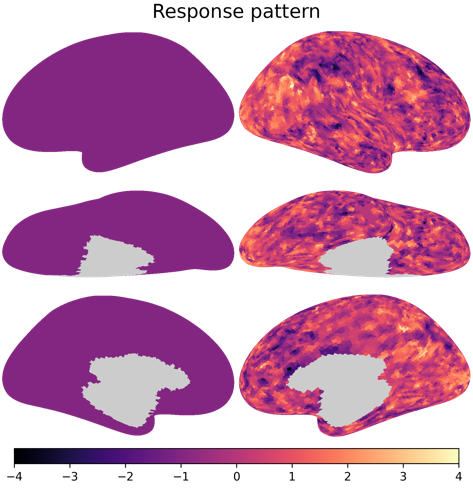

In [11]:
nb.plot([lh_minus_one, dm[47,:]],
        cmap='magma', vmax=4, vmin=-4, title='Response pattern')

In [12]:
# You can also load the left hemisphere data and plot both hemispheres (but it takes time)
# nb.plot([dset.get_data(sid, 'forrest', 1, 'l')[47,:], dm[47,:]],
#      cmap='bwr', vmax=4, vmin=-4, title='Response pattern')

### 7. Import searchlight indices

The brain has a complex 3D structure. This can be simplified by representing its surface as a mesh of small triangles. Using the `nb.sls` function, you can extract coordinates from a spherical region on this surface mesh.

`nb.sls` returns the vertex indices for each searchlight as a list of `numpy` arrays. In this step, you will focus on the right hemisphere with a 20 mm radius, using the `onavg` (OpenNeuro Average) template at ico8 resolution.

In [13]:
# cell 7
# Import searchlight indices for the right hemisphere (ico8 resolution)
## searchlight radius = 10, 15, and 20 mm (right hemisphere)
SLS_ico8_10mm_rh = nb.sls('r', 10, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_15mm_rh = nb.sls('r', 15, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_20mm_rh, Dists_ico8_20mm_rh = nb.sls('r', 20, space='onavg-ico32', center_space='onavg-ico8', return_dists=True)
# command structure: nb.sls('hemisphere', radius, vertex apace, center space, option to load file of distances from center to each vertex)
# - 'r': Right hemisphere
# - radius: Searchlight radius in mm
# - space: Vertex space for searchlight calculations (onavg-ico32 in this case)
# - center_space: Resolution of the searchlight center vertices (onavg-ico8)
# - return_dists: Whether to return distances between vertices in the searchlight

In [14]:
print(len(SLS_ico8_10mm_rh), len(SLS_ico8_15mm_rh), len(SLS_ico8_20mm_rh))

607 607 607


We start by extracting the vertex indices for each searchlight. The `nb.sls` function defines the centers of these searchlights based on the low resolution `ico8` space, resulting in 607 vertices that serve as searchlight centers. Then, leveraging the high resolution ico32 space, we identify the vertices within a specified radius around each center, in this case, 10 mm.

Although all the searchlights share the same 607 centers, the number of vertices within each searchlight varies depending on the radius. You can verify this by checking the length of the output arrays as below.

In [15]:
# vertex 0's searchlight in 10 mm radius
SLS_ico8_10mm_rh[0]

array([2525, 2288, 1652, 3359,  612, 2702, 9038,  834, 5731, 3319, 1204,
       9134, 7832, 3580, 7226, 6084, 6216, 6463,  559, 3358, 2458, 8225,
       9526, 6386, 8083, 6425, 9562])

In [16]:
# vertex 0's searchlight in 15 mm radius
SLS_ico8_15mm_rh[0]

array([2525, 2288, 1652, 3359,  612, 2702, 9038,  834, 5731, 3319, 1204,
       9134, 7832, 3580, 7226, 6084, 6216, 6463,  559, 3358, 2458, 8225,
       9526, 6386, 8083, 6425, 9562,  543, 1496, 3221, 4587, 8871, 2832,
        261, 1199, 4456, 2622,  457, 2580, 4717, 2094,  477, 5238, 6443,
       3809, 8748, 5673,  951,  632, 3115, 6588, 6449, 5239, 4947, 2763,
       8649, 5864, 1084, 7738, 7697, 3902, 1896, 7597, 7803, 8342])

In [17]:
# vertex 0's searchlight in 20 mm radius
SLS_ico8_20mm_rh[0]

array([2525, 2288, 1652, 3359,  612, 2702, 9038,  834, 5731, 3319, 1204,
       9134, 7832, 3580, 7226, 6084, 6216, 6463,  559, 3358, 2458, 8225,
       9526, 6386, 8083, 6425, 9562,  543, 1496, 3221, 4587, 8871, 2832,
        261, 1199, 4456, 2622,  457, 2580, 4717, 2094,  477, 5238, 6443,
       3809, 8748, 5673,  951,  632, 3115, 6588, 6449, 5239, 4947, 2763,
       8649, 5864, 1084, 7738, 7697, 3902, 1896, 7597, 7803, 8342, 4031,
       3755, 2816, 5293, 3266, 8072, 8900, 4980, 4062, 1135, 6240, 1643,
       7081, 3043, 4278,  828, 5368, 6082, 4089, 7420, 9470, 2402, 5182,
       7804, 1875,  847, 2829, 2605, 8192, 7133, 6826, 3837, 1289, 7688,
       1870, 3638,  931, 2501,  734, 6857, 3608, 6460, 1285, 5462, 6866,
       7732, 4137, 8624, 4448, 8875, 7433, 5081, 2203, 6698, 7878])

If you set `return_dists=True`, you can check the distance from each vertex to the center of the searchlight.

In [18]:
Dists_ico8_20mm_rh[0]

array([ 1.48304748,  2.61258366,  3.10141759,  3.79217634,  4.28802939,
        4.66836696,  5.00587528,  5.06798309,  5.78989275,  6.0200985 ,
        6.30125702,  6.52689231,  7.13159626,  7.22800534,  7.6159596 ,
        7.7545429 ,  7.82747705,  7.89624676,  8.30505792,  8.9456715 ,
        9.01621693,  9.01687952,  9.06264802,  9.30359958,  9.34427125,
        9.39392963,  9.70150306, 10.09029469, 10.09837002, 10.09868217,
       10.46477979, 10.61984395, 10.68497179, 10.79628171, 10.9601238 ,
       11.26284889, 11.29768772, 11.66229336, 11.77852963, 11.8703167 ,
       11.89513777, 11.99629971, 12.25345858, 12.32949468, 12.35896225,
       12.50638884, 12.6020951 , 12.64712111, 13.02348511, 13.51964008,
       13.57076944, 13.57143343, 13.63020304, 13.63695249, 13.72485909,
       13.92477888, 14.04287915, 14.05583613, 14.07672766, 14.11625699,
       14.25560668, 14.33358632, 14.35914417, 14.44420532, 14.98008685,
       15.02910766, 15.17206928, 15.35882542, 15.38019842, 15.41

### 8. Plot Responses in One Searchlight
We can plot response patterns for one ico8 searchlight (index 262 for FFA).

In [19]:
type(SLS_ico8_20mm_rh), len(SLS_ico8_20mm_rh)

(list, 607)

In [20]:
type(SLS_ico8_20mm_rh[262]), len(SLS_ico8_20mm_rh[262])

(numpy.ndarray, 125)

The ico8 searchlight for right FFA (radius = 20 mm) has 125 vertex indices.

In [21]:
SLS_ico8_20mm_rh[262]

array([6579, 5046, 2891, 2069, 4324, 2188, 7195, 2597, 4337, 4872,  406,
       9215, 4559, 6360, 4141, 1662, 9048, 6314, 5789, 2874, 1635, 6850,
       2691, 2884, 7741, 7662, 1879, 6519,  755, 8054, 5313, 5010, 2947,
       9250, 9465, 2930, 3209, 3371, 6942, 8482, 4354, 1438, 2228, 8246,
       8654, 8879, 8722, 5564, 8753, 3417, 5341, 5934, 1150, 1794, 3924,
       6110, 7088, 1703, 1806,  750, 8768, 2759, 1612, 9227, 3872, 4282,
       5170, 4059, 7942, 7148, 6168, 2954, 5979, 5272, 7584, 6121, 3794,
       4225, 3600,  193, 4474, 2628, 5811, 5224, 1190,  351, 1024, 6975,
       7836, 3085, 6321, 1291, 3606, 6212, 3219,  181, 4247, 8163, 1494,
       7824,  264, 7772, 8511, 1501, 4163, 7723, 1081, 4968, 6925, 2630,
       4911, 3643,  437, 9423, 6921, 3031, 8299, 2560, 4914, 8617, 7491,
       9200, 7353, 6593,    8])

We can extract the data for the right FFA searchlight.

In [22]:
sl_dm = dm[:, SLS_ico8_20mm_rh[262]]
sl_dm.shape

(451, 125)

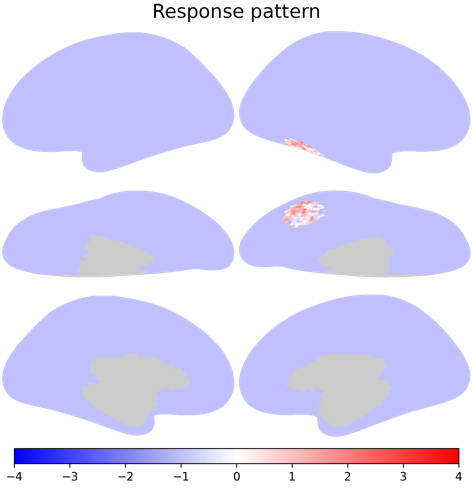

In [23]:
# cell 8
# plot responses in one searchlight (right FFA) for time-point 47
sl = 262  # Searchlight index for the right FFA (corresponds to vertex 262 in ico8 resolution)
tp = 47  # Time-point to visualize (TR = 47)

# Create a background for right hemisphere data (will be blue background for our searchlight data)
rh_minus_one = np.zeros((9666))-1 # Initialize right hemisphere data to -1 (blue background)
rh_sl = rh_minus_one # Copy this to rh_sl, which will be updated with actual data below

# Loop through all vertices within the searchlight (using ico8 resolution with a 20mm radius)
# The searchlight index "sl" (262) corresponds to the right FFA, and we extract the vertices in its searchlight
for vtx in range(len(SLS_ico8_20mm_rh[sl])):
  rh_sl[SLS_ico8_20mm_rh[sl][vtx]] = dm[tp,SLS_ico8_20mm_rh[sl][vtx]] # Copy actual data from dm to rh_sl for plotting

# Plot the updated right hemisphere data with the searchlight values
nb.plot([lh_minus_one, rh_sl], cmap='bwr', vmax=4, vmin=-4, title='Response pattern')

### 9. Funcional Connectivity

To visualize areas that are functionally connected to the right FFA based on similarity, we first calculate the average activity of the data points within the right FFA searchlight for each time point. Then, we measure how much this activity correlates (i.e., covaries over time) with other data points across the brain.

To calculate connectivity vectors across the time series, we will begin by computing the mean activity for each time frame within the target searchlight.


The data matrix dm is structured such that the rows represent time points and the columns represent cortical vertices (`dm(time_series, vertex)`). In this step, we filter the data to focus on the vertices within a defined searchlight using `SLS_ico8_10mm_rh[target_searchlight_vertex]`.

For example, the vertex for the right pFFA in ico8 space is 262 (and 467 for the right pSTS). We can obtain the mean brain activity for each time point within the searchlight of the right pFFA (or right pSTS) using the following code:

In [24]:
# cell 9
# Calculate functional connectivity vectors for two target regions: pFFA (~vertex 262) and pSTS (~vertex 467)

# Calculate the mean time series for the 10mm radius searchlights
mean_ffa = np.mean(dm[:, SLS_ico8_10mm_rh[262]], axis=1)  # Mean time series for pFFA (vertex 262)
mean_sts = np.mean(dm[:, SLS_ico8_10mm_rh[467]], axis=1)  # Mean time series for pSTS (vertex 467)

# calculate connectivity vectors
connvec_ffa = np.corrcoef(mean_ffa, dm.T)[0,1:]
connvec_sts = np.corrcoef(mean_sts, dm.T)[0,1:]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


We also calculated the functional connectivity vectors by correlating the average time series of the target region (either the pFFA or pSTS) with the time series of all other vertices in the brain. This was done using Pearson correlation across the time series.

For example, connvec_ffa stores the correlation coefficients (using `np.corrcoef`) between the average time series of the right pFFA and the time series of all other vertices. These coefficients indicate the degree of functional connectivity between the right pFFA and other regions of the brain.


In [29]:
print(connvec_ffa.shape, connvec_sts.shape)

(9666,) (9666,)



The 9666 data points, which correspond to all the vertices in the right hemisphere, now each have a correlation coefficient representing how strongly their activity is correlated with the activity within the searchlight for either the right pFFA or pSTS.

### 10. Functional Connectivity Plot

You can also plot these connectivity patterns, which consist of correlation coefficients for each vertex. These values show how brain activity correlates between each brain region and the target searchlight area (e.g., pFFA or pSTS) across time.


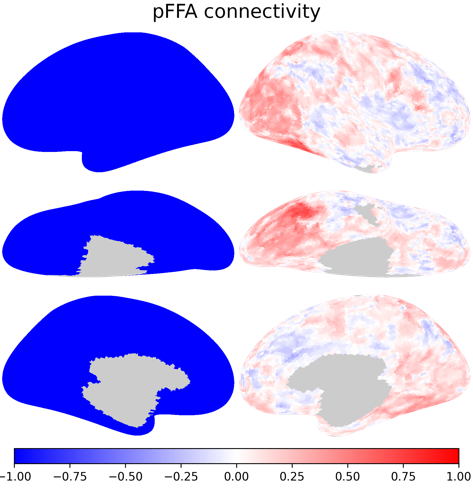

In [34]:
# cell 10
nb.plot([lh_minus_one, connvec_ffa], cmap='bwr', vmax=1, vmin=-1, title='pFFA connectivity')


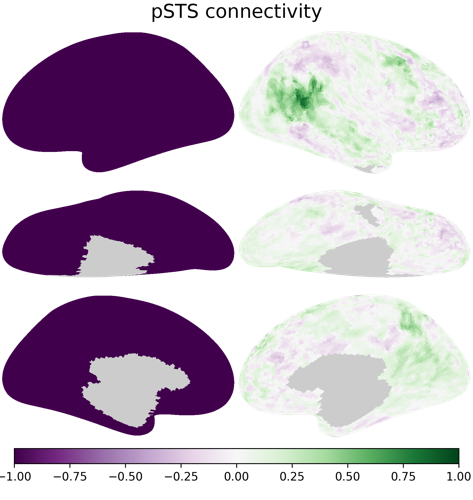

In [37]:
nb.plot([lh_minus_one, connvec_sts], cmap='PRGn', vmax=1, vmin=-1, title='pSTS connectivity')